<a href="https://colab.research.google.com/github/TAUforPython/fuzzy/blob/main/example%20Fuzzy%20Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

example Fuzzy Neutral Network

Источник в статье:
https://ieeexplore.ieee.org/abstract/document/9776208

https://github.com/gregorLen/S-ANFIS-PyTorch/blob/main/README.md

In [ ]:
!pip install scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 8.7 MB/s eta 0:00:00


In [ ]:
!pip install anfis
!pip install matplotlib-venn

In [ ]:
import numpy
import skfuzzy

In [ ]:
!pip install sanfis

In [ ]:
import torch
x = torch.rand(5, 3)
print(x)

tensor([[0.1117, 0.4753, 0.5047],
        [0.0982, 0.2704, 0.7054],
        [0.1184, 0.5948, 0.5471],
        [0.3285, 0.3248, 0.5154],
        [0.6875, 0.0371, 0.1793]])


In [ ]:
# Load modules
import numpy as np
import torch
from sanfis import SANFIS, plottingtools
from sanfis.datagenerators import sanfis_generator

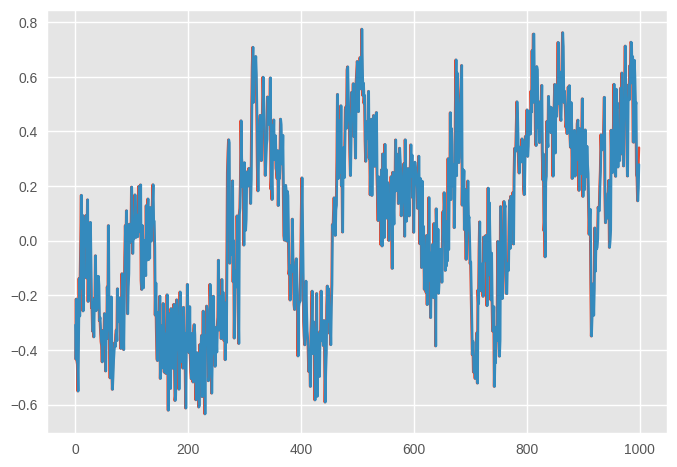

In [ ]:
plt.plot(X)

"""Datagenerator method.

    Args:
        n_obs (int): Number of observations
        n_statevars (int): Number of state variables
        n_input (int): Number of input variables
        memb_func (str, optional): Membership function for the state variables (sigmoid/gaussian). Default to sigmoid.
        batch_size (int, optional): Batch size. Defaults to 16.
        lag (int, optional): Lag parameter. Defaults to 1.
        plot_dgp (bool, optional): Plot data generating process. Defaults to False.
        as_tensor (bool, optional): Data as torch.tensor(). Defaults to True.
    Returns:
        S, S_train, S_valid, X, X_train, X_valid, y, y_train, y_valid: Raw/Train/valid Samples for S, X, and y.
    """

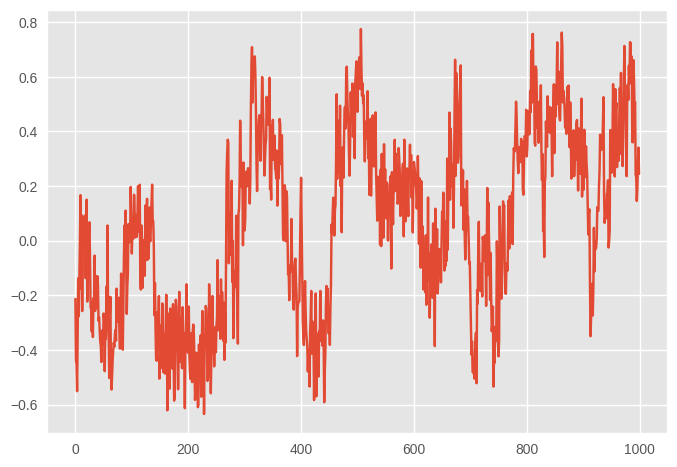

In [ ]:
plt.plot(y)

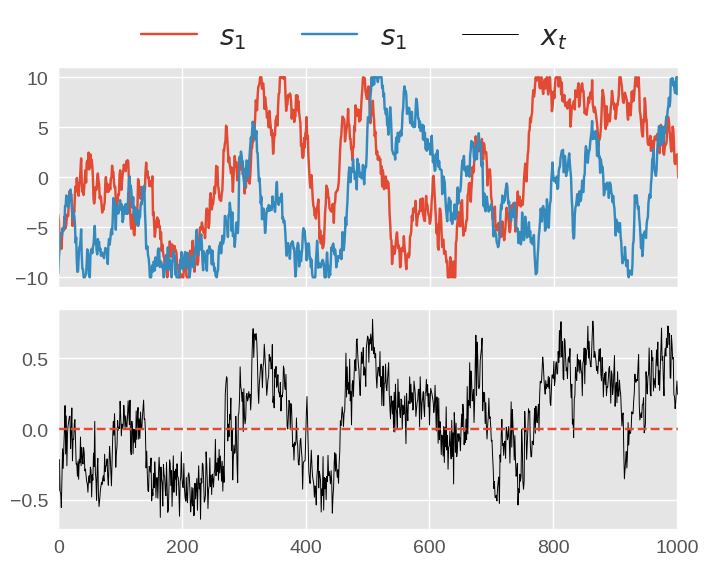

Membership functions (DGP):


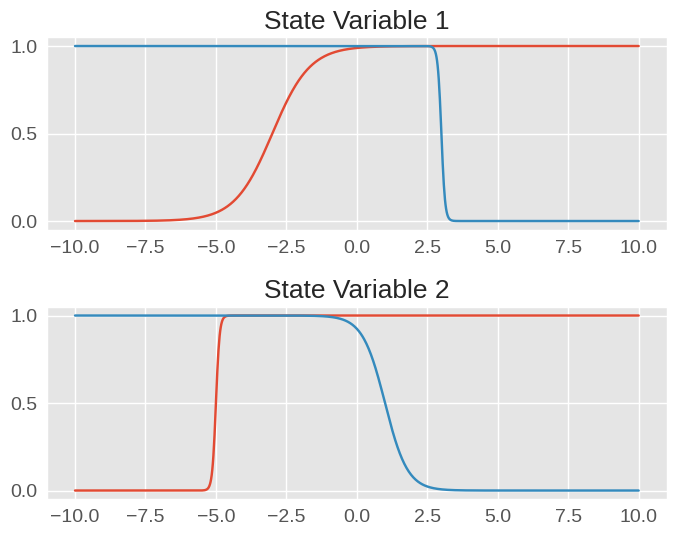

In [ ]:
#As general notation, I call the input the premise part "state" variables s
#and the input of the consequence part "input" or "explanatory" variables x.

# seed for reproducibility
np.random.seed(3)
torch.manual_seed(3)
## Generate Data ##
## First let's generate some data!
## The given example is an AR(2)-process whoose AR-parameters depend on the regime of two independent state variables:
S, S_train, S_valid, X, X_train, X_valid, y, y_train, y_valid, = sanfis_generator.gen_data_ts(
    n_obs=1000, test_size=0.3, plot_dgp=True)

In [ ]:
# list of membership functions
membfuncs = [
    {'function': 'sigmoid',
     'n_memb': 2,
     'params': {'c': {'value': [0.0, 0.0],
                      'trainable': True},
                'gamma': {'value': [-2.5, 2.5],
                          'trainable': True}}},

    {'function': 'sigmoid',
     'n_memb': 2,
     'params': {'c': {'value': [0.0, 0.0],
                      'trainable': True},
                'gamma': {'value': [-2.5, 2.5],
                          'trainable': True}}}
]

Train s-anfis on 700 samples, validate on 300 samples


Training Loop:   1%|1         | 0.1/10 [00:00<01:08,  6.91s/epochs, train_loss=0.267, valid_loss=0.152]


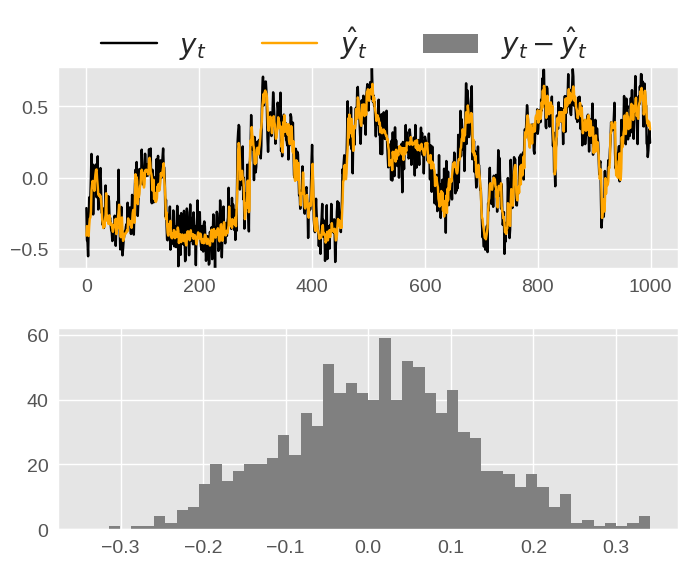

In [ ]:
# make model / set loss function and optimizer
fis = SANFIS(membfuncs=membfuncs, n_input=2, scale='Std')
loss_function = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(fis.parameters(), lr=0.05)

# fit model
history = fis.fit([S_train, X_train, y_train], [S_valid, X_valid, y_valid],
                  optimizer, loss_function, epochs=10)
# eval model
y_pred = fis.predict([S, X])
plottingtools.plt_prediction(y, y_pred)


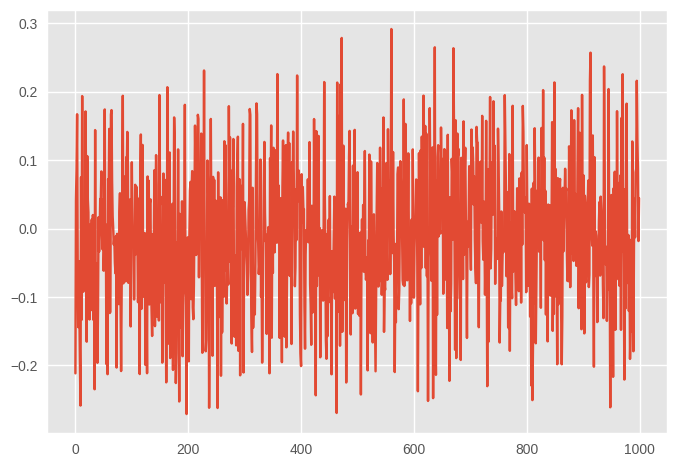

In [ ]:
import matplotlib.pyplot as plt
plt.plot(y_pred-y)